# Linear Regression - MLE

Implementation of the classic linear regression model. Weights are fitted with Maximum Likelihood Estimation using [PyTorch distributions](https://pytorch.org/docs/stable/distributions.html). 

$y \sim \mathcal{N}(\alpha x + \beta, \sigma)$


## Setting up the environment

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

cwd = os.getcwd()
if cwd.endswith('notebook'):
    os.chdir('..')
    cwd = os.getcwd()

In [2]:
sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()

## Generate dataset

In [5]:
α_actual = 2.6
β_actual = 3.3
σ_actual = 0.7

In [6]:
def generate_samples(α, β, σ, min_x=-1, max_x=1, n_samples=500):
    x = np.linspace(min_x, max_x, n_samples)[:, np.newaxis]
    y = α * x + β
    dist = torch.distributions.Normal(torch.from_numpy(y), σ)
    y_sample = dist.sample()
    return x, y, y_sample.detach().numpy()

In [63]:
def plot_line(x, y, y_sample):
    f, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.plot(x.flatten(), y.flatten(), '-', color=palette[0], linewidth=3)
    ax.scatter(x.flatten(), y_sample.flatten(), color=palette[0], alpha=0.8)
    ax.set_xlabel('input x')
    ax.set_ylabel('output y')
    ax.set_title(r'$y \sim N(\alpha x + \beta, \sigma)$')
    return ax

In [64]:
x, y, y_sample = generate_samples(α_actual, β_actual, σ_actual)

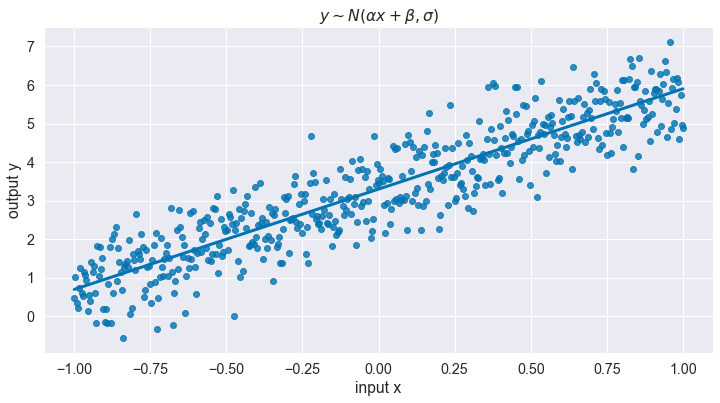

In [65]:
plot_line(x, y, y_sample);

In [66]:
x.shape

(500, 1)

## Define model

In [3]:
class LinearNormal(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.α = torch.nn.Parameter(torch.randn(()))
        self.β = torch.nn.Parameter(torch.randn(()))
        self.s = torch.nn.Parameter(torch.randn(()))
        
    @property
    def sigma(self):
        return F.softplus(self.s)  # ensure σ > 0
        
    def forward(self, x):
        m = self.α * x + self.β
        σ = self.sigma
        return torch.distributions.Normal(m, σ)

In [33]:
def compute_loss(model, x, y):
    out_dist = model(x)
    neg_log_likelihood = -out_dist.log_prob(y)
    return torch.mean(neg_log_likelihood)

def compute_rmse(model, x_test, y_test):
    model.eval()
    pred = model(x_test).sample()
    return torch.sqrt(torch.mean((pred - y_test)**2))

def predict(model, x):
    model.eval()
    out_dist = model(x)
    return out_dist.mean, out_dist.stddev, out_dist

## Fit linear model

In [62]:
def train_one_step(model, optimizer, x_batch, y_batch):
    model.train()
    optimizer.zero_grad()
    loss = compute_loss(model, x_batch, y_batch)
    loss.backward()
    optimizer.step()
    return loss

In [10]:
def train(model, optimizer, x_train, x_val, y_train, y_val, n_epochs, batch_size=64, print_every=10):
    train_losses, val_losses = [], []
    for epoch in range(n_epochs):
        batch_indices = sample_batch_indices(x_train, y_train, batch_size)
        
        batch_losses_t, batch_losses_v, batch_rmse_v = [], [], []
        for batch_ix in batch_indices:
            b_train_loss = train_one_step(model, optimizer, x_train[batch_ix], y_train[batch_ix])

            model.eval()
            b_val_loss = compute_loss(model, x_val, y_val)
            b_val_rmse = compute_rmse(model, x_val, y_val)

            batch_losses_t.append(b_train_loss.detach().numpy())
            batch_losses_v.append(b_val_loss.detach().numpy())
            batch_rmse_v.append(b_val_rmse.detach().numpy())
            
        train_loss = np.mean(batch_losses_t)
        val_loss = np.mean(batch_losses_v)
        val_rmse = np.mean(batch_rmse_v)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if epoch == 0 or (epoch + 1) % print_every == 0:
            print(f'Epoch {epoch+1} | Validation loss = {val_loss:.4f} | Validation RMSE = {val_rmse:.4f}')
        
    _, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.plot(range(1, n_epochs + 1), train_losses, label='Train loss')
    ax.plot(range(1, n_epochs + 1), val_losses, label='Validation loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Overview')
    ax.legend()
    
    return train_losses, val_losses


def sample_batch_indices(x, y, batch_size, rs=None):
    if rs is None:
        rs = np.random.RandomState()
    
    train_ix = np.arange(len(x))
    rs.shuffle(train_ix)
    
    n_batches = int(np.ceil(len(x) / batch_size))
    
    batch_indices = []
    for i in range(n_batches):
        start = i + batch_size
        end = start + batch_size
        batch_indices.append(
            train_ix[start:end].tolist()
        )

    return batch_indices    

In [11]:
def compute_train_test_split(x, y, test_size):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    return (
        torch.from_numpy(x_train),
        torch.from_numpy(x_test),
        torch.from_numpy(y_train),
        torch.from_numpy(y_test),
    )

In [12]:
model = LinearNormal()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [13]:
x_train, x_test, y_train, y_test = compute_train_test_split(x, y_sample, test_size=0.2)

Epoch 1 | Validation loss = 4.9112 | Validation RMSE = 4.1082
Epoch 100 | Validation loss = 3.1718 | Validation RMSE = 3.4923
Epoch 200 | Validation loss = 2.6229 | Validation RMSE = 2.9915
Epoch 300 | Validation loss = 2.3606 | Validation RMSE = 2.5459
Epoch 400 | Validation loss = 2.1753 | Validation RMSE = 2.1109
Epoch 500 | Validation loss = 1.9857 | Validation RMSE = 1.6687
Epoch 600 | Validation loss = 1.7233 | Validation RMSE = 1.2193
Epoch 700 | Validation loss = 1.3585 | Validation RMSE = 0.8441
Epoch 800 | Validation loss = 1.1334 | Validation RMSE = 0.7471
Epoch 900 | Validation loss = 1.1287 | Validation RMSE = 0.7469
Epoch 1000 | Validation loss = 1.1314 | Validation RMSE = 0.7478
Epoch 1100 | Validation loss = 1.1293 | Validation RMSE = 0.7464
Epoch 1200 | Validation loss = 1.1280 | Validation RMSE = 0.7465
Epoch 1300 | Validation loss = 1.1290 | Validation RMSE = 0.7469
Epoch 1400 | Validation loss = 1.1302 | Validation RMSE = 0.7468
Epoch 1500 | Validation loss = 1.1296

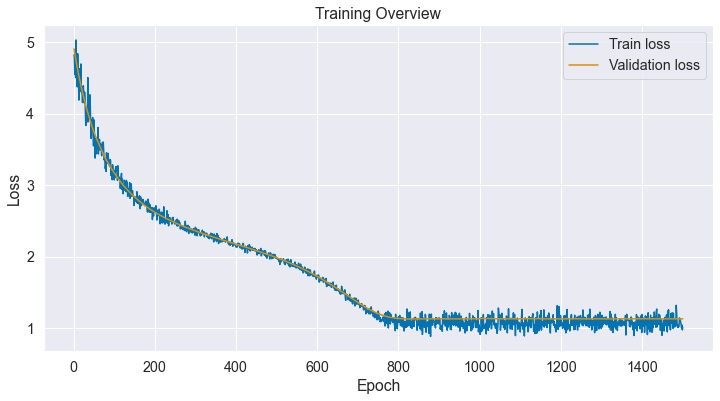

In [14]:
train(model, optimizer, x_train, x_test, y_train, y_test, n_epochs=1500, print_every=100);

## Validation

In [34]:
val_rmse = float(compute_rmse(model, x_test, y_test).detach().numpy())
print(f'Validation RMSE = {val_rmse}')

Validation RMSE = 1.0705470582382548


In [19]:
val_r2 = r2_score(y_test.detach().numpy(), y_pred_sample.detach().numpy())
print(f'Validation R squared = {val_r2}')

Validation R squared = 0.5051809905129987


In [16]:
y_pred, _, y_dist = predict(model, x_test)
y_pred_sample = y_dist.sample()

## Plot results

In [17]:
def plot_results(x, y, y_sample, y_pred, y_pred_sample):
    f, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.plot(x.flatten(), y.flatten(), '-', color=palette[0], linewidth=2, label='Actual line')
    ax.plot(x.flatten(), y_pred.flatten(), '-', color=palette[1], linewidth=2, label='Predicted line')
    ax.scatter(x.flatten(), y_sample.flatten(), color=palette[0], label='Actual samples')
    ax.scatter(x.flatten(), y_pred_sample.flatten(), color=palette[1], label='Predicted samples')
    ax.set_xlabel('input x')
    ax.set_ylabel('output y')
    ax.legend()
    return ax

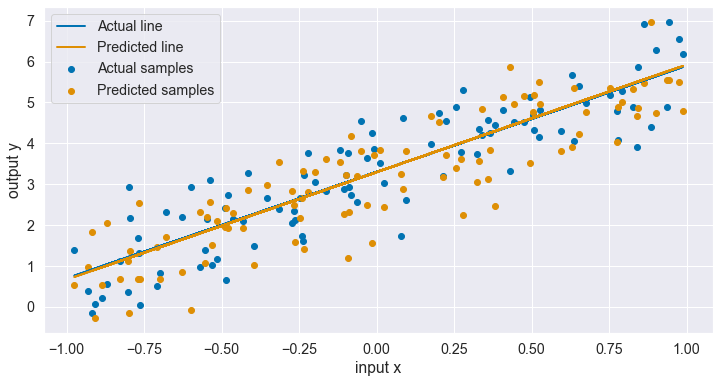

In [18]:
plot_results(
    x_test.detach().numpy(), 
    α_actual * x_test.detach().numpy() + β_actual, 
    y_test.detach().numpy(), 
    y_pred.detach().numpy(), 
    y_pred_sample.detach().numpy()
);

In [24]:
α_hat = float(model.α.detach().numpy())
β_hat = float(model.β.detach().numpy())
σ_hat = float(y_dist.stddev.detach().numpy()[0])

print(f'Actual α = {α_actual:.2f} | Predicted α = {α_hat:.2f}')
print(f'Actual β = {β_actual:.2f} | Predicted β = {β_hat:.2f}')
print(f'Actual σ = {σ_actual:.2f} | Predicted σ = {σ_hat:.2f}')

Actual α = 2.60 | Predicted α = 2.63
Actual β = 3.30 | Predicted β = 3.30
Actual σ = 0.70 | Predicted σ = 0.71
